In [89]:
import numpy as np
import pandas as pd
import scipy.stats as aa
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.feature_selection import chi2
import xgboost as xgb
import matplotlib.pyplot as plt


# Answer question 1¶
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

Individual Contributors (IC) - they don't manage anyone
Middle Managers (MM) - they are the direct bosses of IC
Directors (D) - they are the direct bosses of MM
VP - D direct bosses
Executives (E) - VP direct bosses
CEO - The direct boss of E.

In [90]:
hierarchy = pd.read_csv("company_hierarchy.csv",index_col='employee_id')
hierarchy['level'] = None
hierarchy.loc[hierarchy.dept == 'CEO','level'] = 'CEO'
hierarchy.head(5)

,boss_id,dept,level
employee_id,,,
46456,175361.0,sales,None
104708,29733.0,HR,None
120853,41991.0,sales,None
142630,171266.0,HR,None
72711,198240.0,sales,None


In [91]:
hierarchy.boss_id.value_counts()
hierarchy.loc[hierarchy.level == 'CEO','boss_id'] = -1
hierarchy['boss_id'] = hierarchy.boss_id.astype(int)

#set the level for each employee

def setlevel(boss_level,level):
    boss_ids = hierarchy.loc[hierarchy.level == boss_level,:].index
    is_suborinate = np.in1d(hierarchy.boss_id,boss_ids)
    hierarchy.loc[is_suborinate,'level']= level
setlevel('CEO','E')
setlevel('E','VP')
setlevel('VP','D')
setlevel('D','MM')
setlevel('MM','IC')
hierarchy.head(5)

,boss_id,dept,level
employee_id,,,
46456,175361,sales,IC
104708,29733,HR,IC
120853,41991,sales,IC
142630,171266,HR,MM
72711,198240,sales,IC


In [92]:
hierarchy.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Answer question 2
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [93]:
hierarchy['subordinates'] = 0

def count_subs(s):
    num_direct_subs = s.shape[0]
    num_indirect_subs = s.sum()
    return num_direct_subs+num_indirect_subs

def caculate_subordinates(sub_level):
    num_subs = hierarchy.loc[hierarchy.level == sub_level,:].groupby('boss_id')['subordinates'].agg(count_subs)
    hierarchy.loc[num_subs.index,'subordinates'] = num_subs
    
caculate_subordinates('IC')
caculate_subordinates('MM')
caculate_subordinates('D')
caculate_subordinates('VP')
caculate_subordinates('E')

hierarchy.head(5)


,boss_id,dept,level,subordinates
employee_id,,,,
46456,175361,sales,IC,0
104708,29733,HR,IC,0
120853,41991,sales,IC,0
142630,171266,HR,MM,16
72711,198240,sales,IC,0


In [94]:
hierarchy.loc[hierarchy.level == 'CEO','subordinates']

employee_id
61554    9999
Name: subordinates, dtype: int64

In [95]:
hierarchy.shape[0]

10000

# Answer question 3¶
Build a model to predict the salary of each employee.

In [96]:
employee = pd.read_csv('employee.csv',index_col = 'employee_id')
employee = employee.join(hierarchy)
employee.head(10)

,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,subordinates
employee_id,,,,,,,,,
138719,0,273000.0,Master,M,2,43602,engineering,IC,0
3192,0,301000.0,Bachelor,F,1,87847,sales,IC,0
114657,0,261000.0,Master,F,2,180854,sales,IC,0
29039,0,86000.0,High_School,F,4,88370,HR,IC,0
118607,0,126000.0,Bachelor,F,3,23565,sales,IC,0
91334,0,221000.0,PhD,F,2,62990,sales,IC,0
101901,1,194000.0,PhD,M,12,7558,engineering,MM,6
171111,1,119000.0,Master,F,1,30468,engineering,IC,0
23443,1,217000.0,PhD,M,8,130585,sales,IC,0


In [97]:
employee.salary =employee.salary / 1000
employee.to_csv("all_employees.csv",index_label="employee_id")

In [117]:
X = employee.copy()
X['is_Male'] = (X.sex == 'M').astype(int)
del X['sex']

degrees = ['High_School','Bachelor','Master','PhD']
levels = ['IC','MM','D','VP','E','CEO']
degree_dict = {}
level_dict = {}
for i,degree in enumerate(degrees):
    degree_dict[degree] = i+1
for i, level in enumerate(levels):
    level_dict[level] = i+1
    
X['degree'] = X['degree_level'].map(degree_dict)

del X['degree_level']
del X['boss_id']

X['level'] = X['level'].map(level_dict)
X = pd.get_dummies(X)
del X['dept_CEO']

X.head(10)


,signing_bonus,salary,yrs_experience,level,subordinates,is_Male,degree,dept_HR,dept_engineering,dept_marketing,dept_sales
employee_id,,,,,,,,,,,
138719,0,273.0,2,1,0,1,3,0,1,0,0
3192,0,301.0,1,1,0,0,2,0,0,0,1
114657,0,261.0,2,1,0,0,3,0,0,0,1
29039,0,86.0,4,1,0,0,1,1,0,0,0
118607,0,126.0,3,1,0,0,2,0,0,0,1
91334,0,221.0,2,1,0,0,4,0,0,0,1
101901,1,194.0,12,2,6,1,4,0,1,0,0
171111,1,119.0,1,1,0,0,3,0,1,0,0
23443,1,217.0,8,1,0,1,4,0,0,0,1


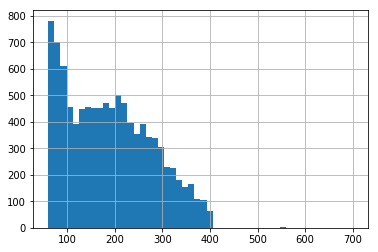

In [118]:
X.salary.hist(bins = 50)
plt.show()

In [119]:
X.salary = np.log(X.salary)

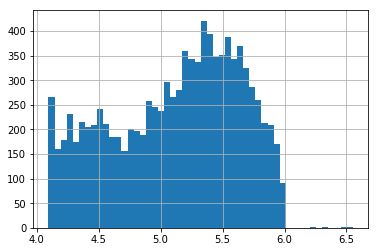

In [120]:
X.salary.hist(bins = 50)
plt.show()

In [121]:
X.groupby('level').salary.agg(['count','mean'])

,count,mean
level,,
1,9000,5.112835
2,800,5.136089
3,160,5.256181
4,35,5.496709
5,4,6.327854
6,1,6.551080


In [122]:
#Remove the CEO data
X = X.loc[X.level != 6]

In [123]:
y = X.salary
del X['salary']

In [124]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 999)
# no validation matrix needed since we will use 5-folder cross_validation

In [125]:
X_train.level.value_counts()

1    6321
2     541
3     110
4      25
5       2
Name: level, dtype: int64

In [126]:
X_test.level.value_counts()

1    2679
2     259
3      50
4      10
5       2
Name: level, dtype: int64

In [127]:
train_matrix = xgb.DMatrix(X_train,y_train)
test_matrix = xgb.DMatrix(X_test,y_test)


In [128]:
params = {}
params['silent'] = 1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
# params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

# If verbose_eval is True then the evaluation metric on the validation set is printed at each boosting stage.
cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True, 
                    seed = 999)

[0]	train-rmse:4.18682+0.00266679	test-rmse:4.18676+0.0102356
[1]	train-rmse:3.77297+0.00252939	test-rmse:3.77276+0.00998854
[2]	train-rmse:3.40045+0.00238197	test-rmse:3.40006+0.00968435
[3]	train-rmse:3.06539+0.00238432	test-rmse:3.06506+0.00923855
[4]	train-rmse:2.76422+0.00223854	test-rmse:2.76391+0.00903457
[5]	train-rmse:2.49405+0.00240693	test-rmse:2.49373+0.00869328
[6]	train-rmse:2.25133+0.00210432	test-rmse:2.25104+0.00828693
[7]	train-rmse:2.03369+0.00183935	test-rmse:2.03342+0.00813511
[8]	train-rmse:1.83846+0.00172684	test-rmse:1.8381+0.00783532
[9]	train-rmse:1.6635+0.00169229	test-rmse:1.66317+0.00776763
[10]	train-rmse:1.50677+0.00156961	test-rmse:1.5065+0.00766204
[11]	train-rmse:1.367+0.00164051	test-rmse:1.36674+0.00778122
[12]	train-rmse:1.24223+0.00179103	test-rmse:1.24201+0.00769205
[13]	train-rmse:1.13114+0.00156768	test-rmse:1.13089+0.00756197
[14]	train-rmse:1.03228+0.00157431	test-rmse:1.03215+0.00749936
[15]	train-rmse:0.944805+0.001508	test-rmse:0.944652+0.0

In [129]:
n_best_trees = cv_results.shape[0]
n_best_trees

53

In [130]:
#train on all training data
watchlist = [(train_matrix,'train')]
bst = xgb.train(params,train_matrix,n_best_trees,watchlist)

[0]	train-rmse:4.18652
[1]	train-rmse:3.77153
[2]	train-rmse:3.39879
[3]	train-rmse:3.06371
[4]	train-rmse:2.76249
[5]	train-rmse:2.49301
[6]	train-rmse:2.24989
[7]	train-rmse:2.03247
[8]	train-rmse:1.83694
[9]	train-rmse:1.66218
[10]	train-rmse:1.50629
[11]	train-rmse:1.36654
[12]	train-rmse:1.2421
[13]	train-rmse:1.13081
[14]	train-rmse:1.03201
[15]	train-rmse:0.944448
[16]	train-rmse:0.866969
[17]	train-rmse:0.798524
[18]	train-rmse:0.73798
[19]	train-rmse:0.685468
[20]	train-rmse:0.63999
[21]	train-rmse:0.600317
[22]	train-rmse:0.566054
[23]	train-rmse:0.536896
[24]	train-rmse:0.511979
[25]	train-rmse:0.490369
[26]	train-rmse:0.472139
[27]	train-rmse:0.456674
[28]	train-rmse:0.444029
[29]	train-rmse:0.433289
[30]	train-rmse:0.424315
[31]	train-rmse:0.4169
[32]	train-rmse:0.410877
[33]	train-rmse:0.405871
[34]	train-rmse:0.401706
[35]	train-rmse:0.398229
[36]	train-rmse:0.39533
[37]	train-rmse:0.393113
[38]	train-rmse:0.391029
[39]	train-rmse:0.389519
[40]	train-rmse:0.388057
[41]	t

In [131]:
y_predict = bst.predict(test_matrix,ntree_limit = n_best_trees)
np.sqrt(mean_squared_error(y_test,y_predict))


0.39447751306388984

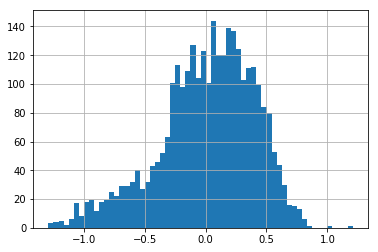

In [132]:
(y_test-y_predict).hist(bins=60)
plt.show()

In [133]:
bst.save_model('gbt.model')

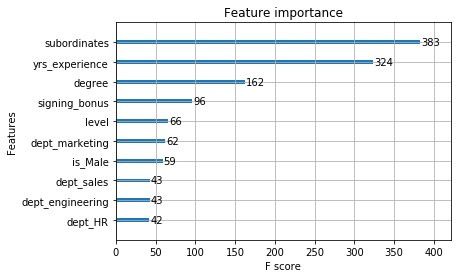

In [134]:
xgb.plot_importance(bst)
plt.show()


from above plot of feature importance, we can see the main factors impacting salaries includes:

"years of experience". this is fair, more experienced deserve high salary
'n_subordinates'. #subordinates has some relationship with level. higher level, more subordinates, more salary

evaluate the model on whole data set

# Residual Analysis

In [135]:
whole_Matrix = xgb.DMatrix(X)
whole_predict = bst.predict(whole_Matrix,ntree_limit = n_best_trees)

In [136]:
predictResult =pd.DataFrame({'y_pred':np.exp(whole_predict),'y_true':np.exp(y)})
predictResult['bias'] = predictResult.y_true-predictResult.y_pred

In [137]:
predictResult = predictResult.join(employee)
del predictResult['salary']
predictResult.head(10)

,y_pred,y_true,bias,signing_bonus,degree_level,sex,yrs_experience,boss_id,dept,level,subordinates
employee_id,,,,,,,,,,,
138719,221.656158,273.0,51.343842,0,Master,M,2,43602,engineering,IC,0
3192,169.760071,301.0,131.239929,0,Bachelor,F,1,87847,sales,IC,0
114657,172.098343,261.0,88.901657,0,Master,F,2,180854,sales,IC,0
29039,80.985832,86.0,5.014168,0,High_School,F,4,88370,HR,IC,0
118607,171.906006,126.0,-45.906006,0,Bachelor,F,3,23565,sales,IC,0
91334,175.032532,221.0,45.967468,0,PhD,F,2,62990,sales,IC,0
101901,203.985901,194.0,-9.985901,1,PhD,M,12,7558,engineering,MM,6
171111,225.506668,119.0,-106.506668,1,Master,F,1,30468,engineering,IC,0
23443,172.356781,217.0,44.643219,1,PhD,M,8,130585,sales,IC,0


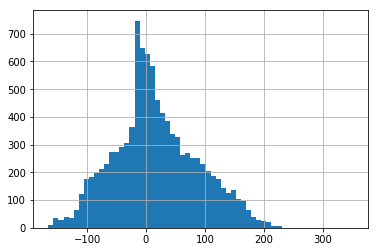

In [138]:
predictResult.bias.hist(bins = 60)
plt.show()

distribution is normal, so this is acceptable

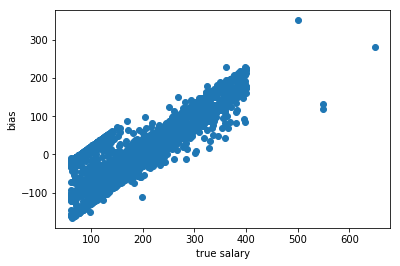

In [139]:
plt.scatter(predictResult.y_true,predictResult.bias)
plt.xlabel('true salary')
plt.ylabel('bias')
plt.show()


from above plot, we can see that, employee with high salary are more likely to be overpaid.

Do the chi2 analysis to see which factor will influence the bias

In [140]:
def chisquare_test_on_bias():
    X = predictResult.copy()
    del X['y_pred']
    del X['y_true']
    del X['boss_id']

    X['degree_level'] = X.degree_level.map(degree_dict)
    X['level'] = X.level.map(level_dict)

    X['is_male'] = (X.sex == 'M').astype(int)
    del X['sex']

    dept_lb_encoder = LabelEncoder()
    X['dept'] = dept_lb_encoder.fit_transform(X.dept)
    
    y = (X.bias > 0)
    del X['bias']
    
    scores,pvalues = chi2(X,y)
    return pd.DataFrame({'score': scores, 'pvalue': pvalues},index = X.columns).sort_values(by='pvalue')
chisquare_test_on_bias()

,score,pvalue
subordinates,3511.375418,0.000000
dept,18.873285,0.000014
signing_bonus,1.732290,0.188119
is_male,0.722912,0.395190
degree_level,0.621964,0.430318
yrs_experience,0.364303,0.546126
level,0.294576,0.587303


In [141]:
def chi2_test_on_bias():
    X = predictResult.copy()
    y = (X.bias>0)
    X['degree_level']= X['degree_level'].map(degree_dict)
    X['level'] = X['level'].map(level_dict)
    X.dept = LabelEncoder().fit_transform(X.dept)
    X['is_male'] = (X.sex == 'M').astype(int)
    
    del X['y_pred']
    del X['y_true']
    del X['bias']
    del X['sex']
    del X['boss_id']
    
    score,p_value = chi2(X,y)
    #return X.head(10)
    return pd.DataFrame({'score':score,'p_value':p_value},index = X.columns).sort_values(by = 'p_value',ascending = True)

chi2_test_on_bias()

,score,p_value
subordinates,3511.375418,0.000000
dept,18.873285,0.000014
signing_bonus,1.732290,0.188119
is_male,0.722912,0.395190
degree_level,0.621964,0.430318
yrs_experience,0.364303,0.546126
level,0.294576,0.587303


if we set threshold as 0.1, n_subordinates, department, are four factors impacting whether the employee is overpaid or underpaid.

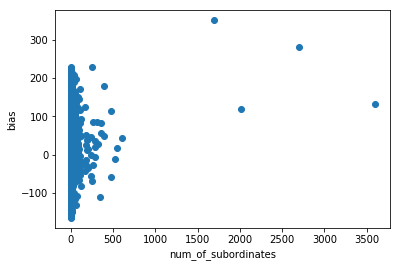

In [142]:
plt.scatter(predictResult.subordinates,predictResult.bias)
plt.xlabel('num_of_subordinates')
plt.ylabel('bias')
plt.show()

Thus from above plot, we can see that, more subordinates (i.e., higher level), more positive bias, means more likely to be overpaid.

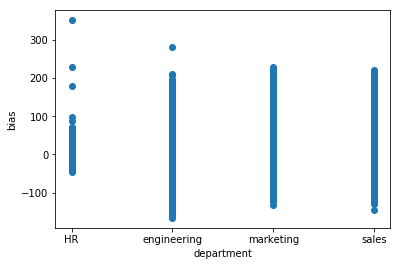

In [143]:
plt.scatter(predictResult.dept,predictResult.bias)
plt.xlabel('department')
plt.ylabel('bias')
plt.show()

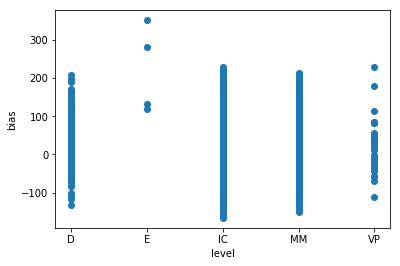

In [144]:
plt.scatter(predictResult.level,predictResult.bias)
plt.xlabel('level')
plt.ylabel('bias')
plt.show()